In [3]:
using MatrixNetworks
using Distributions
using Clustering
using NPZ
using BenchmarkTools, Compat
using DelimitedFiles
using SparseArrays
using Printf
using LinearAlgebra
using Plots
using SphericalGraphEmbedding
using LaTeXStrings

### Compute NMI between the retrieved and the true community


========== Graph 1/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 190 iterations
  2.636667 seconds (27.78 k allocations: 1.287 GiB, 10.68% gc time, 5.52% compilation time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 9
Number of communities: 39
Modularity: 0.731805353586849
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.4006299272198067, 0.2651677881090127, 0.17690233422467588, 0.10042660902243435, 0.05551053262806436]
 -------------------------------------------- 
  6.263675 seconds (711.41 k allocations: 1.610 GiB, 6.25% gc time, 2.32% compilation time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 186 iterations
  2.120426 seconds (5.20 k allocations: 1.259 GiB, 10.89% gc time)
 -------------- Clustering -----

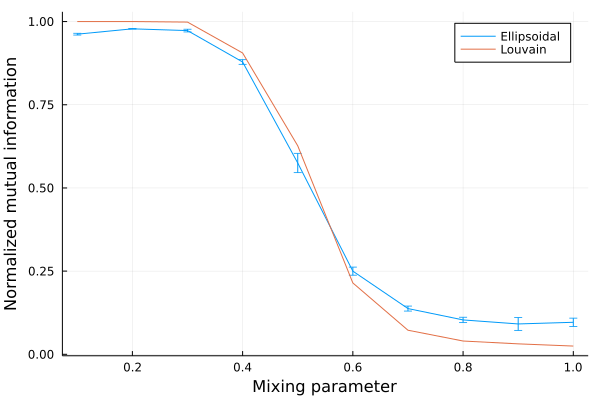

In [4]:
## Compute NMI for each graph
path = "data/LFR_data/"
n_graphs = 10

# Set parameters of simulations

n_it_PPM = 30000;
t = 1e-8;
n_clusters = 100;
d0 = 100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 10
n_updates = 50  # max total by default

shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
mus=zeros(Float64,n_graphs)
NMIs=zeros(Float64,n_graphs,n_rep)
NMIs_louvain=zeros(Float64,n_graphs)

for g=1:n_graphs
    println("\n========== Graph $g/$(n_graphs) ==========")
    
    # load communities
    community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)
    community_louvain = readdlm(path*"louvain_communities"*string(g-1)*".txt",Int)

    # load graph
    edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

    n_nodes = size(community_true)[1]
    n_edges = size(edgeList)[1]

    # construct sparse adjacency matrix from list of edges
    adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
    adj = adj+adj' 
    # only the upper triangular part of adjacency matrix was stored

    # keep only the largest connected component
    adj,vertices = largest_component(adj);
    
    community_true = community_true[vertices]
    community_true = rename_com_unique(community_true)
    
    community_louvain = community_louvain[vertices]
    community_louvain = rename_com_unique(community_louvain)

    # load parameters
    LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
    mu = parse(Float64, split(LFR_parameters[4],"=")[2]) 
    # extract mixing marameter (not very robust)
    mus[g] = mu
    
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")
        
         _,community,_ = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,d0)

        NMIs[g,j] = mutualinfo(community_true,community);
    end
    NMIs_louvain[g] = mutualinfo(community_true,community_louvain);
end

# Plot Normalized mutual information vs Miwing parameter

m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(mus, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")

plot!(mus, NMIs_louvain,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Louvain")
savefig("figures/nmi_vs_mu.pdf")
plot!()


### Estimating the impact of $d_0$ on embedding quality

mu=0.4
========== d0 step 1/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 287 iterations
  0.362099 seconds (7.63 k allocations: 201.539 MiB, 13.16% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10
Number of updates: 8
Number of communities: 11
Modularity: 0.37466833682822354
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21964528257835847, 0.21305166212883736, 0.18077641861664012, 0.12819160822097453, 0.09906352465759254]
 -------------------------------------------- 
  3.082234 seconds (2.27 M allocations: 1.539 GiB, 9.30% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 283 iterations
  0.471568 seconds (7.53 k allocations: 198.725 MiB, 7.08% gc time)
 -------------- Clustering ------- 
dimension of embedding used for c

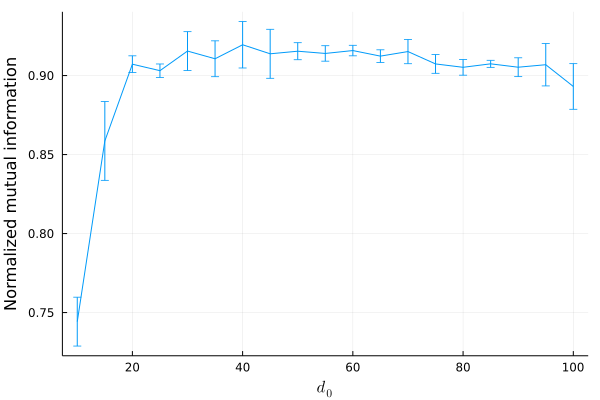

In [5]:
g = 4

# Set parameters of simulations
n_it_PPM = 30000;
t = 1e-10;
n_clusters = 100;
d0s = 10:5:100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
NMIs=zeros(Float64,length(d0s),n_rep)

# load communities
community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes = size(community_true)[1]
n_edges = size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj = adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true = community_true[vertices]
community_true = rename_com_unique(community_true)

# load parameters
LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
mu = parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(d0s)
    println("\n========== d0 step $i/$(length(d0s)) ==========")
    d0=d0s[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")
        
        _,community,_ = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,d0)

        NMIs[i,j] = mutualinfo(community_true,community);
    end
end


# Plot Normalized mutual information vs d0
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(d0s, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"d_0",
ylabel = "Normalized mutual information",
legend = false)

savefig("figures/nmi_vs_d0__mu"*string(mu)*".pdf")
plot!()


### Test impact of n_clusters

mu=0.4
========== n_clusters step 1/10 ==========



  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 284 iterations
  3.075282 seconds (7.84 k allocations: 1.925 GiB, 10.21% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 12
Number of communities: 10
Modularity: 0.34539615030581233
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21986630141869595, 0.21284932149915894, 0.18084811533563833, 0.12812262968777674, 0.09913540848873273]
 -------------------------------------------- 
  6.564509 seconds (3.01 M allocations: 3.591 GiB, 9.39% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 313 iterations
  2.952958 seconds (8.62 k allocations: 2.122 GiB, 10.63% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 12
Numbe

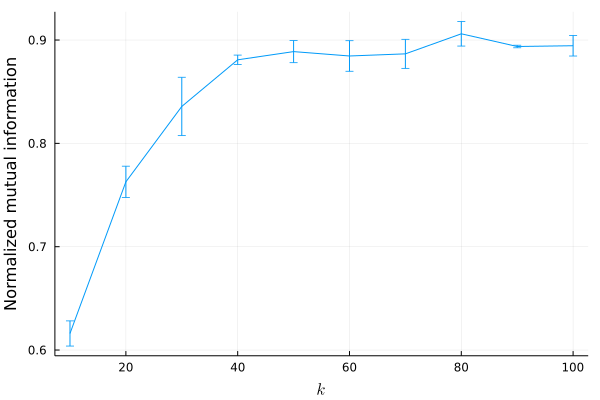

In [6]:
g = 4

# Set parameters of simulations
n_it_PPM = 30000;
t = 1e-10;
n_clusters_list = 10:10:100;
d0 = 100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 100;
# we advise : n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
NMIs=zeros(Float64,length(n_clusters_list),n_rep)

# load communities
community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes = size(community_true)[1]
n_edges = size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj = adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true = community_true[vertices]
community_true = rename_com_unique(community_true)

# load parameters
LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
mu = parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(n_clusters_list)
    println("\n========== n_clusters step $i/$(length(n_clusters_list)) ==========")
    n_clusters = n_clusters_list[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")

        # embed cluster
        _,community,_ = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,d0)

        NMIs[i,j] = mutualinfo(community_true,community);
    end
end

# Plot Normalized mutual information vs d0
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(n_clusters_list, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"k",
ylabel = "Normalized mutual information",
legend = false)

savefig("figures/nmi_vs_nclusters__mu"*string(mu)*".pdf")
plot!()
